In [1]:
import pandas as pd
import numpy as np
import json
import itertools
from itertools import combinations
from sklearn.metrics.pairwise import cosine_similarity
from random import sample
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import random
from scipy.stats import entropy, mannwhitneyu

In [2]:
users = pd.read_csv('../../src/data/distribuitions/hub_bridge_df.csv')
users = users.drop(columns=[
    'external_degree','pct_internal','pct_external',
    'z_internal','betweenness','internal_degree'
])

topics = pd.read_csv('../../src/nlp/topic_modeling/topic_data.csv')
echo_cambers = pd.read_csv('../../src/research_question/echo_chambers_results.csv')

echo_cambers = echo_cambers.drop(columns=['community_type'], errors='ignore')

community_info = users.merge(topics, left_on='id', right_on='author', how='inner').drop(columns=['id_x'])
global_info = community_info.merge(echo_cambers, on='community_id', how='inner', suffixes=('_user', '_echo'))

global_info.head()

,degree,community_id,community_type,is_hub,is_bridge,author,id_y,type,topic,topic_id,num_users,num_hubs,num_bridges,intra_mean,inter_mean,intra_std,inter_std,echo_score,echo_class
0,32,0,Very Strong,False,False,-Dead-Eye-Duncan-,1lyvcd4,post,19_housing_rent_cities_homeless,19,3508,120,174,0.547294,0.43939,0.128893,0.14213,0.38159,Weak/No Echo Chamber
1,32,0,Very Strong,False,False,-Dead-Eye-Duncan-,n2x7kqt,comment,19_housing_rent_cities_homeless,19,3508,120,174,0.547294,0.43939,0.128893,0.14213,0.38159,Weak/No Echo Chamber
2,32,0,Very Strong,False,False,-Dead-Eye-Duncan-,n2wzdd9,comment,0_vote_epstein_democrats_voters,0,3508,120,174,0.547294,0.43939,0.128893,0.14213,0.38159,Weak/No Echo Chamber
3,32,0,Very Strong,False,False,-Dead-Eye-Duncan-,n2x722x,comment,19_housing_rent_cities_homeless,19,3508,120,174,0.547294,0.43939,0.128893,0.14213,0.38159,Weak/No Echo Chamber
4,32,0,Very Strong,False,False,-Dead-Eye-Duncan-,n2x69bh,comment,19_housing_rent_cities_homeless,19,3508,120,174,0.547294,0.43939,0.128893,0.14213,0.38159,Weak/No Echo Chamber


/tmp/ipykernel_27102/42075136.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=topic_diversity, x='echo_class', y='topic_entropy', palette="Spectral")


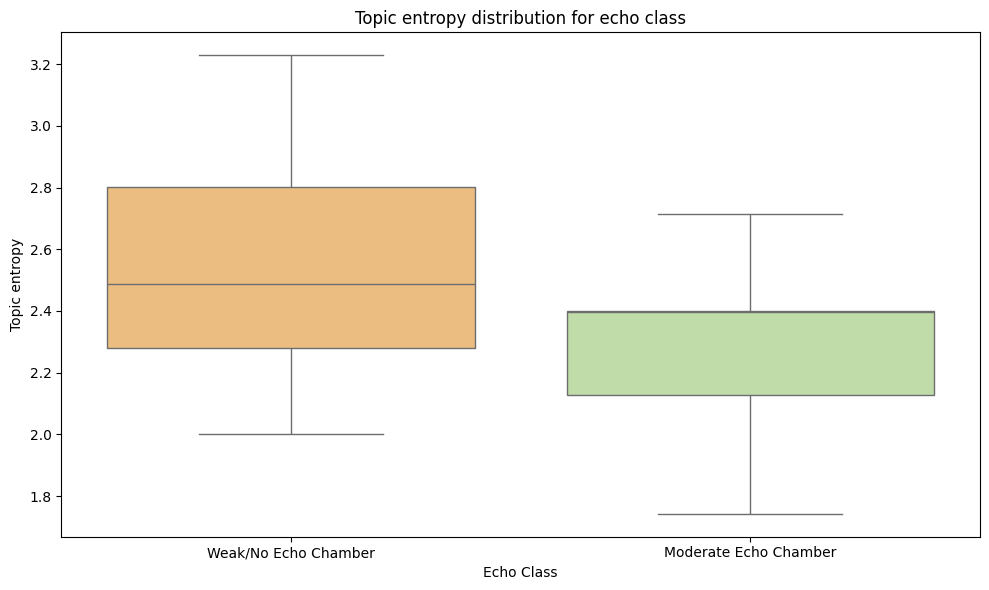

In [3]:
# Topic diversity in echo chambers - entropy
community_topic_counts = pd.read_csv('../../src/nlp/topic_modeling/community_topic_counts.csv')

community_topic_counts_with_type = community_topic_counts.merge(
    global_info[['community_id', 'echo_class']].drop_duplicates(),
    on='community_id',
    how='left'
)

topic_diversity = community_topic_counts_with_type.groupby('community_id').agg({
    'count': lambda x: entropy(x/x.sum()),
    'echo_class': 'first'
}).reset_index().rename(columns={'count': 'topic_entropy'})


plt.figure(figsize=(10, 6))
sns.boxplot(data=topic_diversity, x='echo_class', y='topic_entropy', palette="Spectral")

counts = topic_diversity.groupby('echo_class')['community_id'].nunique()
for i, ct in enumerate(topic_diversity['echo_class'].unique()):
    n = counts.get(ct, 0)
plt.title("Topic entropy distribution for echo class")
plt.xlabel("Echo Class")
plt.ylabel("Topic entropy")
plt.tight_layout()
plt.show()

Plotting topics distribuition in Echo Chambers

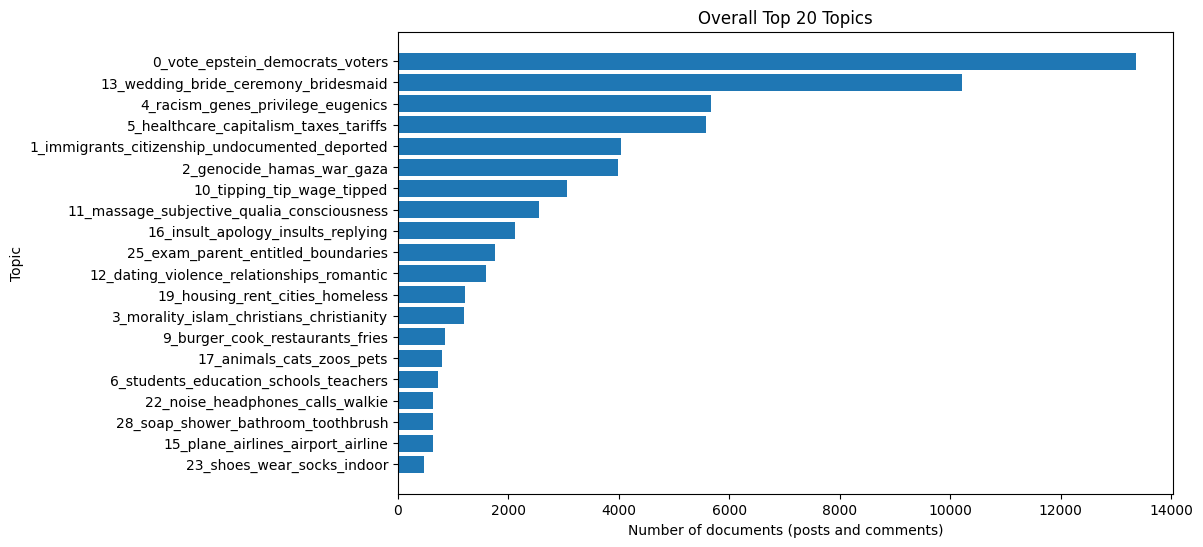

In [4]:
topic_counts = global_info.loc[global_info['echo_class'] == 'Moderate Echo Chamber']
topic_counts = topic_counts['topic'].value_counts().reset_index().head(20)
topic_counts.columns = ['topic', 'count']

plt.figure(figsize=(10,6))
plt.barh(topic_counts['topic'], topic_counts['count'])
plt.ylabel("Topic")
plt.xlabel("Number of documents (posts and comments)")
plt.title("Overall Top 20 Topics")
plt.gca().invert_yaxis()
plt.show()

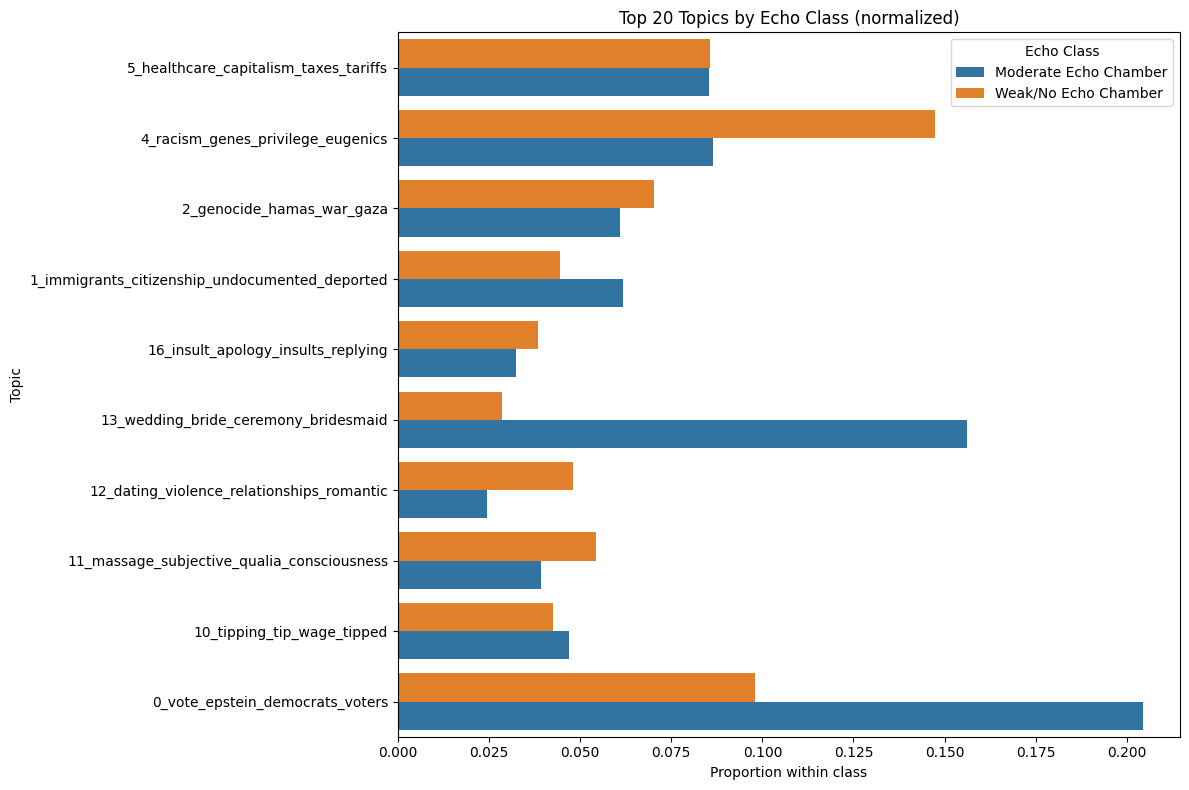

In [5]:
# Distribuzione normalizzata per classe
topic_counts = (
    global_info.groupby(['echo_class', 'topic'])
      .size()
      .reset_index(name='count')
)

# Calcolo percentuale all’interno di ogni classe
topic_counts['pct'] = (
    topic_counts.groupby('echo_class')['count']
    .transform(lambda x: x / x.sum())
)

#  Selezione dei top 20 topic globali (basati sui conteggi totali, non sulle percentuali)
top_topics = (
    topic_counts.groupby('topic')['count']
    .sum()
    .nlargest(10)
    .index
)

topic_counts = topic_counts[topic_counts['topic'].isin(top_topics)]

# --- Plot ---
plt.figure(figsize=(12,8))
sns.barplot(
    data=topic_counts,
    y='topic', x='pct', hue='echo_class',
    orient='h'
)

plt.ylabel("Topic")
plt.xlabel("Proportion within class")
plt.title("Top 20 Topics by Echo Class (normalized)")
plt.gca().invert_yaxis()
plt.legend(title="Echo Class")
plt.tight_layout()
plt.show()


In [6]:
temporal_dataset = pd.read_csv('../../src/nlp/cleaned_dataset.csv')
temporal_dataset = temporal_dataset.drop(columns=['type', 'clean_text'], errors='ignore')

global_info = global_info.merge(temporal_dataset, left_on='id_y', right_on='id', how='left' )

In [7]:
# Retrieving post by month
global_info['date'] = pd.to_datetime(global_info['date'], utc=True)
global_info['month'] = global_info['date'].dt.to_period('M').dt.to_timestamp()
global_info.head()

/tmp/ipykernel_27102/1923256526.py:3: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  global_info['month'] = global_info['date'].dt.to_period('M').dt.to_timestamp()


,degree,community_id,community_type,is_hub,is_bridge,author_x,id_y,type,topic,topic_id,...,intra_mean,inter_mean,intra_std,inter_std,echo_score,echo_class,author_y,id,date,month
0,32,0,Very Strong,False,False,-Dead-Eye-Duncan-,1lyvcd4,post,19_housing_rent_cities_homeless,19,...,0.547294,0.43939,0.128893,0.14213,0.38159,Weak/No Echo Chamber,-Dead-Eye-Duncan-,1lyvcd4,2025-07-13 15:18:35+00:00,2025-07-01
1,32,0,Very Strong,False,False,-Dead-Eye-Duncan-,n2x7kqt,comment,19_housing_rent_cities_homeless,19,...,0.547294,0.43939,0.128893,0.14213,0.38159,Weak/No Echo Chamber,-Dead-Eye-Duncan-,n2x7kqt,2025-07-13 16:34:29+00:00,2025-07-01
2,32,0,Very Strong,False,False,-Dead-Eye-Duncan-,n2wzdd9,comment,0_vote_epstein_democrats_voters,0,...,0.547294,0.43939,0.128893,0.14213,0.38159,Weak/No Echo Chamber,-Dead-Eye-Duncan-,n2wzdd9,2025-07-13 15:53:01+00:00,2025-07-01
3,32,0,Very Strong,False,False,-Dead-Eye-Duncan-,n2x722x,comment,19_housing_rent_cities_homeless,19,...,0.547294,0.43939,0.128893,0.14213,0.38159,Weak/No Echo Chamber,-Dead-Eye-Duncan-,n2x722x,2025-07-13 16:31:51+00:00,2025-07-01
4,32,0,Very Strong,False,False,-Dead-Eye-Duncan-,n2x69bh,comment,19_housing_rent_cities_homeless,19,...,0.547294,0.43939,0.128893,0.14213,0.38159,Weak/No Echo Chamber,-Dead-Eye-Duncan-,n2x69bh,2025-07-13 16:27:46+00:00,2025-07-01


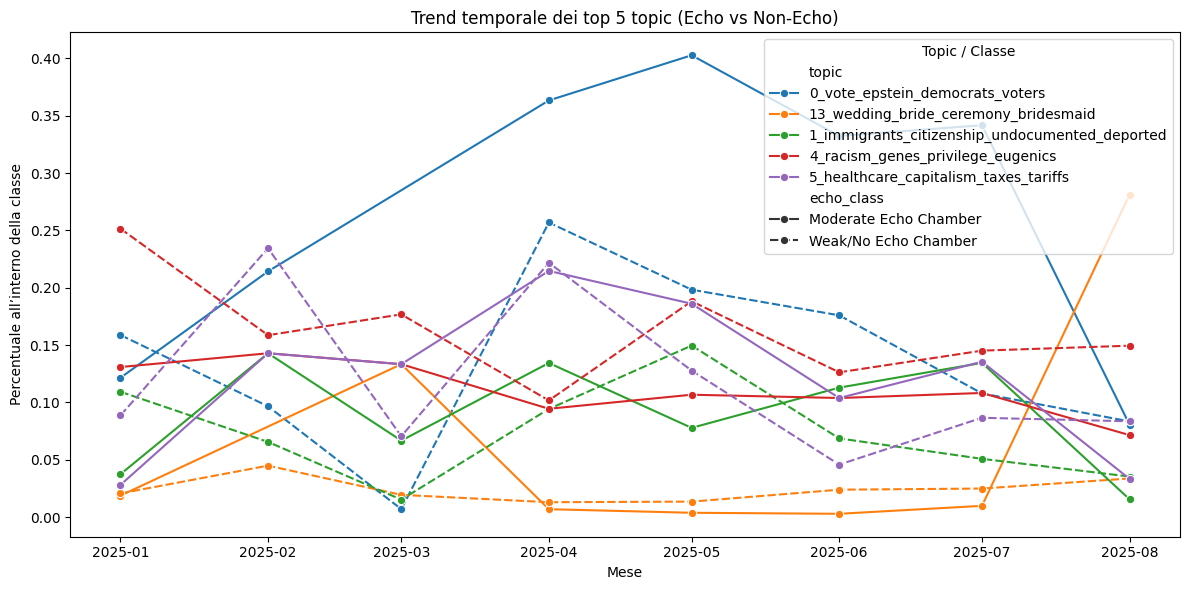

In [8]:

# Frequenza per (classe, topic, mese)
topic_time = (
    global_info.groupby(['echo_class', 'topic', 'month'])
    .size()
    .reset_index(name='count')
)

# Normalizzazione: % sul totale per classe e mese
topic_time['pct'] = (
    topic_time.groupby(['echo_class', 'month'])['count']
    .transform(lambda x: x / x.sum())
)

# Selezioniamo i top 5 topic più frequenti nelle echo
top_topics = (
    topic_time[topic_time['echo_class'] == "Moderate Echo Chamber"]
    .groupby('topic')['count']
    .sum()
    .nlargest(5)
    .index
)

plot_data = topic_time[topic_time['topic'].isin(top_topics)]

# Plot lineare
plt.figure(figsize=(12,6))
sns.lineplot(
    data=plot_data,
    x='month',
    y='pct',
    hue='topic',
    style='echo_class',
    marker="o"
)
plt.title("Trend temporale dei top 5 topic (Echo vs Non-Echo)")
plt.xlabel("Mese")
plt.ylabel("Percentuale all’interno della classe")
plt.legend(title="Topic / Classe")
plt.tight_layout()
plt.show()
